### Encoder: DTW

In [1]:
from pygsig.datasets.subduction import SubductionZone
import pandas as pd

test_dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/test.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2020-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

In [2]:
from pygsig.datasets.subduction import SubductionZone
import pandas as pd

train_dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/train.geojson',
                         site_path='datasets/subduction/location.geojson',
                         start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2019-12-31 11:59:00+0000', tz='UTC'),
                         download=False)

Compute the DTW distance matrix

In [5]:
import numpy as np
from tqdm import tqdm
from tslearn.metrics import dtw
import torch


num_nodes = train_dataset.X.shape[0]

DTW = torch.zeros((num_nodes, num_nodes))

with tqdm(total=int(num_nodes*(num_nodes-1)/2)) as pbar:
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i <j:
                DTW[i,j] = dtw(train_dataset.X[i, :, :], train_dataset.X[j, :, :])
                DTW[j,i] = DTW[i,j]
            pbar.update(1)

7396it [09:12, 13.38it/s]                          


Visualize DTW matrix

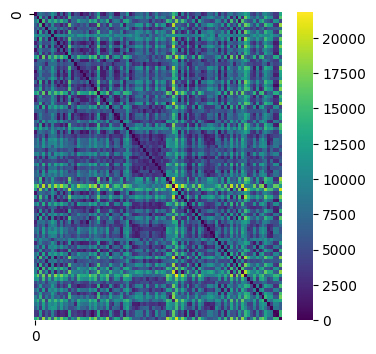

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
sns.heatmap(DTW.numpy(), cmap='viridis', xticklabels=num_nodes, yticklabels=num_nodes)
plt.show()

Save results

In [10]:
import torch
torch.save(DTW, 'encoders/geonet/DTW.pt')

Create graph from DTW data

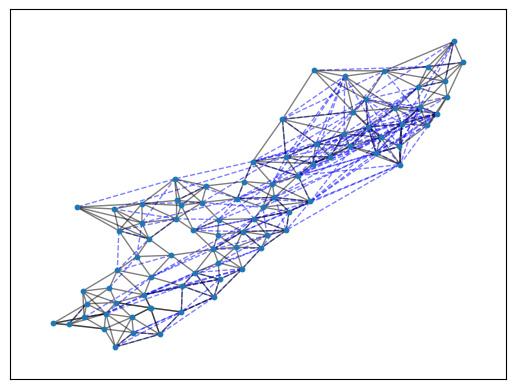

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

pct = 0.95 # percentile to cut off
adj_matrix = np.exp(-DTW.numpy()**2/np.std(DTW.numpy().flatten())**2) - np.identity(num_nodes) # adjaceny matrix with RBF kernel
adj_matrix[adj_matrix < np.quantile(adj_matrix.flatten(),pct)] = 0
G_dtw = nx.from_numpy_array(adj_matrix, create_using=nx.Graph)

g_knn = train_dataset.get_graph(k=5)
G_knn = nx.from_edgelist(g_knn.edge_index.numpy().T)

pos = {i: train_dataset.gdf_location.geometry.values[i].coords[0][0:2] for i in range(num_nodes)}

plt.figure()
nx.draw_networkx_nodes(G_dtw, pos=pos, node_size=10)
nx.draw_networkx_edges(G_dtw, pos=pos, edge_color='blue', alpha=0.5,style='dashed')
nx.draw_networkx_edges(G_knn, pos=pos, edge_color='black', alpha=0.5)
plt.show()


TSNE does not relaly work for embedding dimension $d > 3$. We will try UMAP and MDS

Model: GCNClassification
Number of parameters: 68289
Split 1/4


100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Split 2/4


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Split 3/4


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Split 4/4


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

Accuracy: 0.9001 ± 0.0810, F1: 0.4614 ± 0.3234, Precision: 0.5529 ± 0.3636, Recall: 0.4333 ± 0.3571


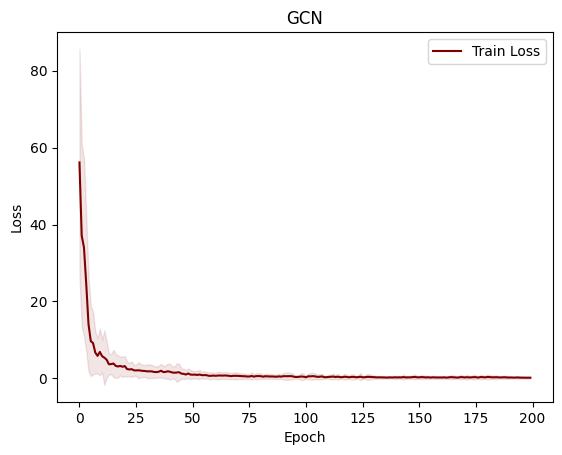

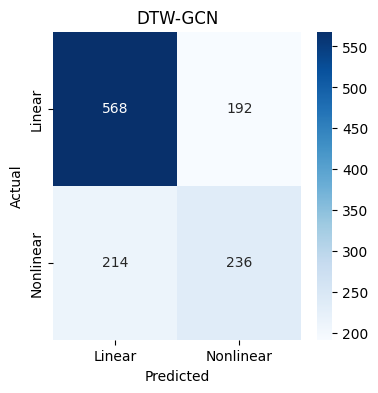

In [6]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler
import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNClassification,MLPClassification
from pygsig.graph import split_nodes
from pygsig.transforms import SignatureFeatures,TS2VecFeatures,RandomFeatures,DTWFeatures
import signatory
import seaborn as sns

# graph & task
test_dataset.task = 'classification'
seq = test_dataset.get_graph(k=5)

# Set up parameters
num_nodes = seq.num_nodes
num_splits = 4
num_trials = 10
num_epochs = 200
learning_rate = 1e-3
in_channels = 1000
num_hidden = 64

print_during_training = False
retrain_encoder = True

# Create class weights for handling imbalance
positive_class_count = (seq.y == 1).sum().item()
negative_class_count = (seq.y == 0).sum().item()
class_weights = torch.tensor([negative_class_count / positive_class_count], dtype=torch.float)

# Initialize models
models = []
models.append(GCNClassification(num_channels=[in_channels, num_hidden, num_hidden, 1]))

model_names = ['GCN']

# Create a mask for valid labels (ignoring -1)
label_mask = seq.y != -1

# Criterion for binary classification with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Apply signature transformation to the sequential data to obtain static graph
encoder = DTWFeatures(num_features=in_channels,dtw_path='encoders/geonet/DTW.pt')
data = encoder(seq)


for model_number, model in enumerate(models):
    print(f'Model: {model._get_name()}')
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize arrays to store losses
    train_losses = np.zeros([num_splits, num_trials, num_epochs])
    eval_losses = np.zeros([num_splits, num_trials, num_epochs])
    
    accuracy = np.zeros([num_splits, num_trials])
    f1 = np.zeros([num_splits, num_trials])
    precision = np.zeros([num_splits, num_trials])
    recall = np.zeros([num_splits, num_trials])
    confusion_matrices = np.zeros([num_splits, num_trials, 2, 2])
    predictions = np.zeros([num_splits,num_trials,num_nodes])
    
    splits = split_nodes(num_nodes, num_splits, seed=31) # no validation
    
    for split in range(num_splits):
        print(f'Split {split+1}/{num_splits}')
        train_indices, test_indices = splits[split]
        
        # Create masks for training, evaluation, and testing
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        train_mask[train_indices] = True
        test_mask[test_indices] = True
        
        # Apply label mask to exclude -1 values
        valid_train_mask = train_mask & label_mask
        valid_test_mask = test_mask & label_mask

        with tqdm(total=num_trials, disable=print_during_training) as pbar:
            for trial in range(num_trials):
                model.reset_parameters()
                for epoch in range(num_epochs):
                    # Training phase
                    model.train()
                    optimizer.zero_grad()
                    out = model(data.x, data.edge_index)
                    
                    # Apply valid train mask to loss computation
                    train_loss = criterion(out[valid_train_mask], data.y[valid_train_mask].unsqueeze(1))
                    train_loss.backward()
                    optimizer.step()

                    # Evaluation phase
                    model.eval()
                    with torch.no_grad():
                        test_loss = criterion(out[valid_test_mask], data.y[valid_test_mask].unsqueeze(1))
                        train_losses[split, trial, epoch] = train_loss.item()
                    
                    if epoch % 10 == 0 and print_during_training:
                        print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}')

                # Evaluation on test set with valid labels
                with torch.no_grad():
                    out = model(data.x, data.edge_index, data.edge_attr)
                    y_true = data.y.unsqueeze(1)
                    y_pred = (out > 0.5).float()  # Binary predictions
                    
                    # Compute performance metrics
                    confusion_matrices[split, trial] = confusion_matrix(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    accuracy[split, trial] = accuracy_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy())
                    f1[split, trial] = f1_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    precision[split, trial] = precision_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(),zero_division=0)
                    recall[split, trial] = recall_score(y_true[valid_test_mask].numpy(), y_pred[valid_test_mask].numpy(), zero_division=0)
                    predictions[split,trial] = y_pred.squeeze().numpy()

                    # Update the progress bar
                    pbar.update(1)


    # Print results for the model
    print(f'Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}, F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}, Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}, Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}')

    # Plotting the training and evaluation loss
    avg_train_losses = np.mean(train_losses, axis=(0, 1))
    std_train_losses = np.std(train_losses, axis=(0, 1))
 

    plt.figure()
    plt.plot(avg_train_losses, label='Train Loss', color='maroon')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_names[model_number]}')
    plt.legend()
    plt.show()


    # Plot confusion matrices
    cm = confusion_matrices.sum(axis=(0,1))
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=['Linear', 'Nonlinear'], yticklabels=['Linear', 'Nonlinear'])
    plt.title(f'DTW-GCN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()